# Subjectivity analysis
Use [subjective/objective movie review data](https://www.cs.cornell.edu/people/pabo/movie-review-data/) to train a classifier to filter out objective sentences as a preprocessing step to sentiment analysis.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

## Load and label data
The data of reviews are assumed to be subjective, and the plot descriptions are assumed to be objective.

In [21]:
subjective_df = pd.read_csv('subjectivity_data/plot.tok.gt9.5000', encoding='ISO-8859-1', #alternatively 'latin-1'
                            sep='\n', header=None, names=['sentence'])
objective_df  = pd.read_csv('subjectivity_data/quote.tok.gt9.5000', encoding='ISO-8859-1', #alternatively 'latin-1'
                            sep='\n', header=None, names=['sentence'])
subjective_df['label'] = 1
objective_df['label'] = 0

In [25]:
data = pd.concat([objective_df, subjective_df], ignore_index=False)
data.head()

,sentence,label
0,"smart and alert , thirteen conversations about...",0
1,"color , musical bounce and warm seas lapping o...",0
2,it is not a mass-market entertainment but an u...,0
3,a light-hearted french film about the spiritua...,0
4,my wife is an actress has its moments in looki...,0


Split data into train and test sets

In [20]:
from sklearn.model_selection import train_test_split

In [28]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(data.sentence, data.label,
                                                                              test_size=0.3, random_state=100)

Use binary vectorizer

In [31]:
bin_vectorizer = CountVectorizer(strip_accents=None, lowercase=True,
                                 preprocessor=None, tokenizer=None,
                                 stop_words=None, ngram_range=(1, 1),
                                 binary=False)

In [33]:
bin_vectorizer.fit(data.sentence)

CountVectorizer()

In [35]:
train_vec = bin_vectorizer.transform(train_sentences)
test_vec  = bin_vectorizer.transform(test_sentences)

## Train a naïve Bayes classifier
Predict on the test set

In [38]:
m_naive_bayes = MultinomialNB()
m_naive_bayes.fit(train_vec, train_labels)
te_pred = m_naive_bayes.predict(test_vec)

In [45]:
from sklearn.metrics import classification_report

In [46]:
con_mat = classification_report(test_labels, te_pred)

In [47]:
print(con_mat)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1495
           1       0.92      0.90      0.91      1505

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



OK! Use the predicted labels of the sentences to decide which are subjective and objective respectively. The subjective sentences can be used for polarity prediction.

## TODO
- function that returns the NB classifier to another notebook
- minimum-cut based subjectivity classifier interface

# Graph-based subjectivity classification
Method adopted from [A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts by Pang and Lee](https://arxiv.org/abs/cs/0409058). Use proximity information to decide if a sentence should be classified as subjective or objective. Use the naïve Bayes classifier probabilities as weights in a graph and find the minimum cut to separate objective from subjective sentences.

The weights from the source to a sentence is the probability of the sentence being objective (0), and from a sentence to the sink the weight is the probability of the sentence being subjective (1).

Use the package `networkx` for running the min-cut algorithm [`networkx.algorithms.flow.minimum_cut`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.flow.minimum_cut.html).

In [48]:
prob = m_naive_bayes.predict_proba(test_vec)

In [53]:
print(prob)
print(te_pred)

[6.86707273e-01 9.96752600e-01 1.13854921e-05 ... 3.58675235e-04
 8.00644210e-11 3.72291732e-02]
[1 1 0 ... 0 0 0]


In [54]:
to_source = prob[:,0] # objective probability
to_sink = prob[:,1]   # subjective probability

Use an associative weight between sentence nodes $assoc(s_i,s_j) = c\cdot f(j-i) $ for $j-1 \leq T$ and $0$ otherwise, where $f(d)$ is decreasing. Pang and Lee used $c\in[0,1]$ with steps of $0.1$, $T\in\{1,2,3\}$, and $f(d)\in\{1, e^{1-d}, 1/d^2\}$.

In [65]:
def get_assoc_matrix(n_sentences, threshold=3, c=0.5):
    """
    Returns the weight matrix for the nodes
    Input:
        - n_sentences: the number of sentences in the review
        - threshold: the number of sentences that count as being close
        - c: weight (for each class) of the associative function
    """
    A = np.zeros((n_sentences,n_sentences))
    
    for i in range(n_sentences):
        for j in range(i+1, n_sentences):
            if j-i <= threshold:
                d = j-i
                A[i,j] = c*np.exp(1-d)
                A[j,i] = c*np.exp(1-d)
    return A

In [85]:
n_sentences = 8
A = get_assoc_matrix(n_sentences)
if n_sentences < 9:
    print(np.around(A,3))

[[0.    0.5   0.184 0.068 0.    0.    0.    0.   ]
 [0.5   0.    0.5   0.184 0.068 0.    0.    0.   ]
 [0.184 0.5   0.    0.5   0.184 0.068 0.    0.   ]
 [0.068 0.184 0.5   0.    0.5   0.184 0.068 0.   ]
 [0.    0.068 0.184 0.5   0.    0.5   0.184 0.068]
 [0.    0.    0.068 0.184 0.5   0.    0.5   0.184]
 [0.    0.    0.    0.068 0.184 0.5   0.    0.5  ]
 [0.    0.    0.    0.    0.068 0.184 0.5   0.   ]]


__N.B. In the example below we use sentences that are _not_ close to each other, and the classification will _not_ be improved here as a result.__

In [86]:
M = np.zeros((n_sentences+2, n_sentences+2))
M[1:n_sentences+1, 0] = to_source[0:n_sentences]
M[0, 1:n_sentences+1] = to_source[0:n_sentences]

M[n_sentences+1, 1:n_sentences+1] = to_sink[0:n_sentences]
M[1:n_sentences+1, n_sentences+1] = to_sink[0:n_sentences]

M[1:n_sentences+1, 1:n_sentences+1] = A

In [87]:
print(np.around(M,3))

[[0.    0.313 0.003 1.    1.    0.973 1.    0.999 1.    0.   ]
 [0.313 0.    0.5   0.184 0.068 0.    0.    0.    0.    0.687]
 [0.003 0.5   0.    0.5   0.184 0.068 0.    0.    0.    0.997]
 [1.    0.184 0.5   0.    0.5   0.184 0.068 0.    0.    0.   ]
 [1.    0.068 0.184 0.5   0.    0.5   0.184 0.068 0.    0.   ]
 [0.973 0.    0.068 0.184 0.5   0.    0.5   0.184 0.068 0.027]
 [1.    0.    0.    0.068 0.184 0.5   0.    0.5   0.184 0.   ]
 [0.999 0.    0.    0.    0.068 0.184 0.5   0.    0.5   0.001]
 [1.    0.    0.    0.    0.    0.068 0.184 0.5   0.    0.   ]
 [0.    0.687 0.997 0.    0.    0.027 0.    0.001 0.    0.   ]]


In [88]:
import networkx as nx
from networkx.algorithms.flow import minimum_cut
G = nx.convert_matrix.from_numpy_matrix(M)

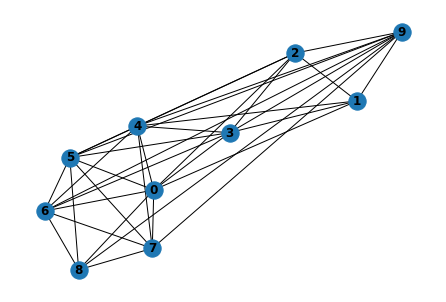

In [91]:
nx.draw(G, with_labels=True, font_weight='bold')

In [102]:
cut_value, partition = minimum_cut(flowG = G, _s=0, _t=n_sentences+1, capacity='weight')

In [104]:
print(partition)
print(te_pred[0:6])

({0, 3, 4, 5, 6, 7, 8}, {9, 2, 1})
[1 1 0 0 0 0]


Sanity check: We disregard the sink and source nodes 0 and 9, and find node 1 and 2 being subjective, and the rest objective, just like we had with the NB classifier. If the emphasis on proximity is increased (e.g. increase $c$ or $T$), the partition might change.